<a href="https://colab.research.google.com/github/Ghat0tkach/creative_qr_generator/blob/main/Creative_qr_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch xformers diffusers transformers accelerate qrcode

In [66]:
#utils
from PIL import Image
import qrcode
from qrcode.constants import ERROR_CORRECT_H



def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


def generate_qr_code(link, size=768):
    # Step 1: Initialize QRCode with error correction level 'H'
    qr = qrcode.QRCode(
        version=1,
        error_correction=ERROR_CORRECT_H,  # Error correction level H (30% of the QR code can be damaged)
        box_size=20,
        border=4,
    )

    # Step 2: Add data (URL or any information)
    qr.add_data(link)
    qr.make(fit=True)

    # Step 3: Create QR code image with fill color and background color
    qr_img = qr.make_image(fill_color="black", back_color="white")

    # Step 4: Resize the QR code to the specified size using a high-quality filter
    qr_img = qr_img.resize((size, size), Image.LANCZOS)

    # Step 5: Return the final QR code image
    return qr_img


In [ ]:
import torch
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel,StableDiffusionUpscalePipeline,DDIMScheduler
from diffusers.utils import load_image


controlnet_qrcode_control = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)



# Pipeline for initial generation with qr-code control
controlnet_qrcode_control_pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet_qrcode_control,
    safety_checker=None,
    torch_dtype=torch.float16
)

upscaled_pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", variant="fp16", torch_dtype=torch.float16
)



In [60]:
controlnet_qrcode_control_pipe.enable_xformers_memory_efficient_attention()
controlnet_qrcode_control_pipe.scheduler = DDIMScheduler.from_config(controlnet_qrcode_control_pipe.scheduler.config)
controlnet_qrcode_control_pipe.enable_model_cpu_offload()

In [ ]:
# create qr image
qr_data = "qr_link"
source_image = generate_qr_code(qr_data, size=768)

condition_image = resize_for_condition_image(source_image, 768)
condition_image

In [ ]:
init_image = load_image("base_image_url")

init_image = resize_for_condition_image(init_image, 768)
init_image

  0%|          | 0/135 [00:00<?, ?it/s]

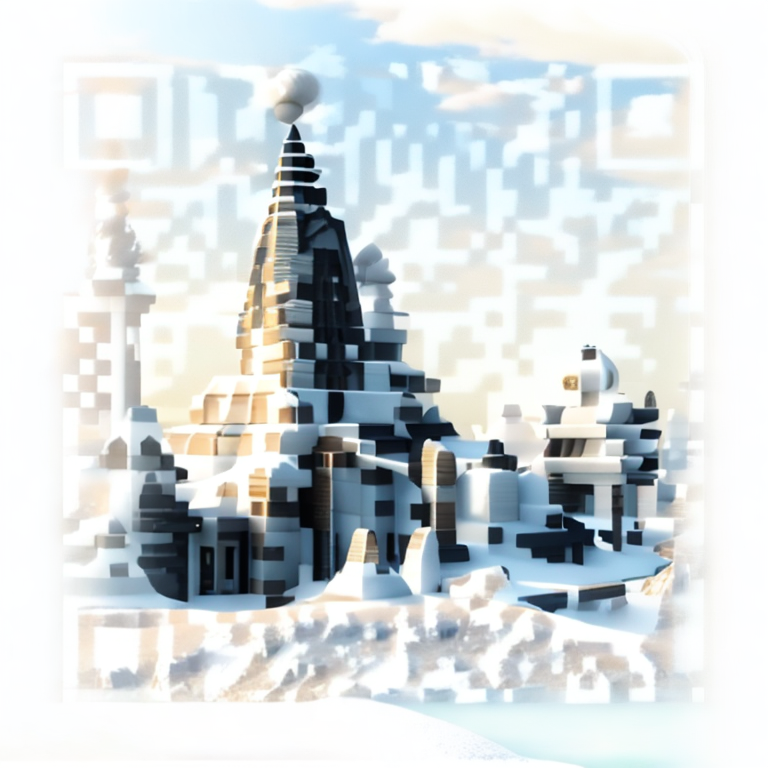

In [71]:
generator = torch.manual_seed(0)

# Generate image with controlnet_qrcode
image = controlnet_qrcode_control_pipe(
    prompt="beautiful city view ancient temples ",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw, worst quality, illustration, drawing",
    image=init_image,
    control_image=condition_image,
    width=768,
    height=768,
    guidance_scale=10,
    controlnet_conditioning_scale=1.5,
    generator=generator,
    strength=0.9,
    num_inference_steps=150
).images[0]

image
